In [2]:
# Standard libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

# For Machine Learning (PyTorch)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

### Update
The only different is the DNN with LogSigmoid function and hidden layers.

Epoch 10000/1000000, Loss: 329.6975
Train R^2:  0.0
Test  R^2:  -1.3770934251730398


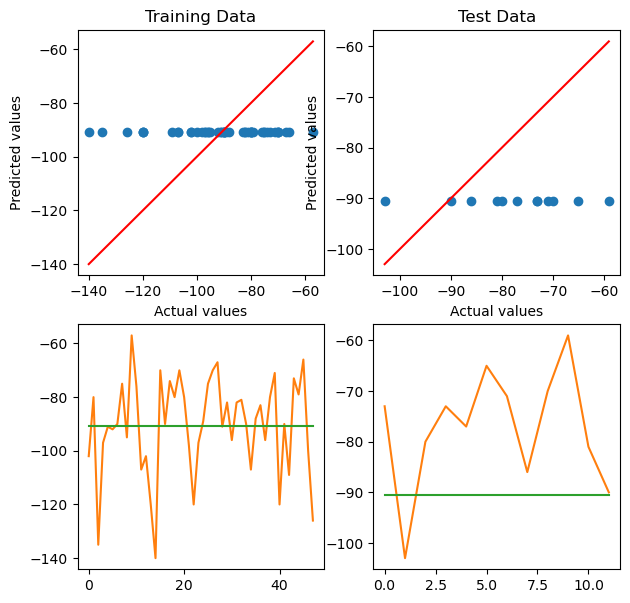

Epoch 20000/1000000, Loss: 329.6975
Train R^2:  0.0
Test  R^2:  -1.3770934251730398


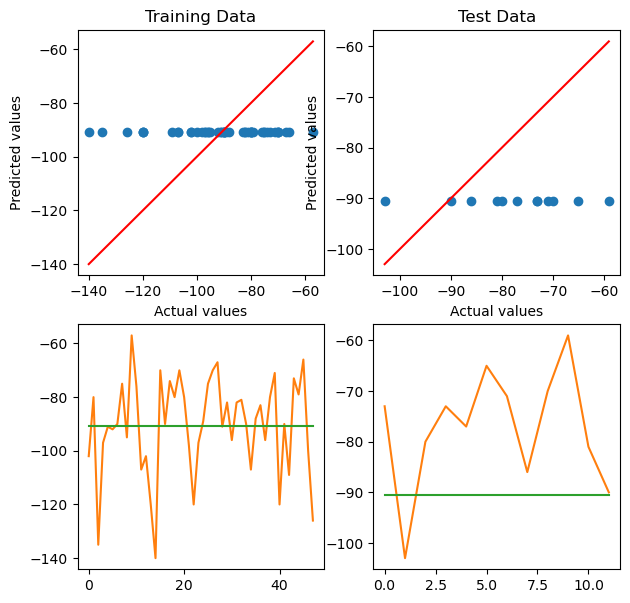

Epoch 30000/1000000, Loss: 329.6975
Train R^2:  0.0
Test  R^2:  -1.3770934251730398


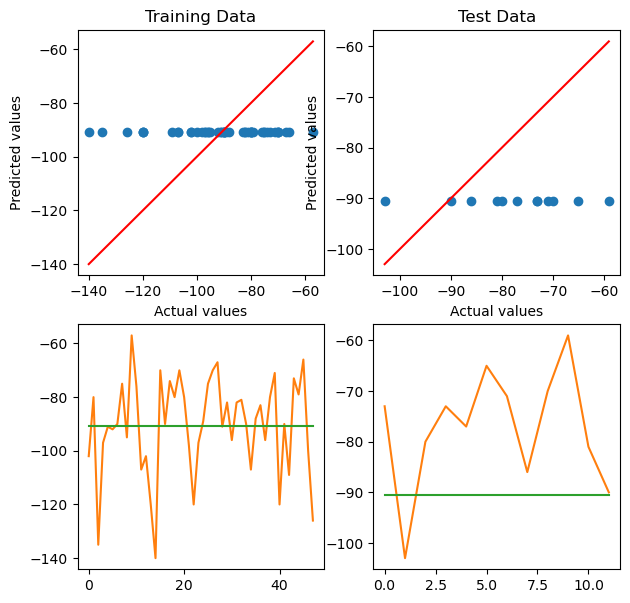

Epoch 40000/1000000, Loss: 329.6975
Train R^2:  0.0
Test  R^2:  -1.3770934251730398


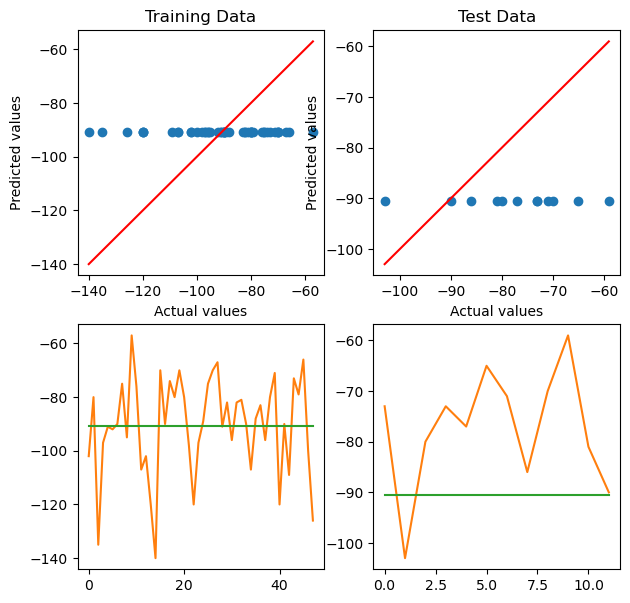

KeyboardInterrupt: 

In [22]:
root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

y_train = np.array(y_train,dtype = np.float32).ravel()
y_test = np.array(y_test,dtype = np.float32).ravel()

# 2. Train the Gradient Boosting Regressor # n = 10000
gbr = GradientBoostingRegressor(n_estimators = 70000, learning_rate = 0.001, max_depth = 4, random_state = 10, tol = 1e-5)
gbr.fit(X_train, y_train)

# Get the predictions from Gradient Boosting Regressor
gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

# Combine the original features and the GBR predictions as new inputs for the Neural Network
X_train_nn = np.hstack([X_train, gbr_train_pred.reshape(-1, 1)])
X_test_nn = np.hstack([X_test, gbr_test_pred.reshape(-1, 1)])

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train_nn, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_nn, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Define the neural network
class DeepNN(nn.Module):
    def __init__(self, input_size = 6, hidden_size = 32, output_size = 1):
        super(DeepNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        #self.fc2 = nn.Linear(hidden_size, hidden_size)
        #self.fc3 = nn.Linear(hidden_size, hidden_size)
        #self.fc4 = nn.Linear(hidden_size, hidden_size)
        #self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)

        self.activation = nn.Sigmoid()  # Logistic sigmoid

    def forward(self, x):
        x = self.activation(self.fc1(x))
        #x = self.activation(self.fc2(x))
        #x = self.activation(self.fc3(x))
        #x = self.activation(self.fc4(x))
        #x = self.activation(self.fc5(x))
        x = self.out(x)
        return x

# Example instantiation
model = DeepNN()

# Loss function (Mean Squared Error for regression)
criterion = nn.MSELoss()

# Optimizer: SGD with momentum
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum = 0.9)

num_epochs = 1000000
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_train)
    y_train_pred = model(X_train)
    y_test_pred = model(X_test)
    loss = criterion(y_train_pred, y_train)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    var_train = r2_score(y_train.data.numpy(), y_train_pred.detach().numpy())
    var_test  = r2_score(y_test.data.numpy(), y_test_pred.detach().numpy())

    # if (epoch+1) % 10 == 0:
    #     print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

    if (epoch+1) % 10000 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item():.4f}")
        print("Train R^2: ", var_train)
        print("Test  R^2: ", var_test)

        fig, axes = plt.subplots(2, 2, figsize = (7, 7))
        axes[0, 0].scatter(y_train, y_train_pred.detach().numpy())
        axes[0, 0].plot([min(y_train.data.numpy()), max(y_train.data.numpy())],[min(y_train.data.numpy()), max(y_train.data.numpy())], color = 'r')
        axes[0, 0].set_title("Training Data")
        axes[0, 0].set_xlabel("Actual values")
        axes[0, 0].set_ylabel("Predicted values")

        axes[0, 1].scatter(y_test, y_test_pred.detach().numpy())
        axes[0, 1].plot([min(y_test.data.numpy()), max(y_test.data.numpy())],[min(y_test.data.numpy()), max(y_test.data.numpy())], color = 'r')
        axes[0, 1].set_title("Test Data")
        axes[0, 1].set_xlabel("Actual values")
        axes[0, 1].set_ylabel("Predicted values")

        axes[1, 0].plot(y_train.data.numpy().squeeze(),'tab:orange', label = 'real')
        axes[1, 0].plot(y_train_pred.detach().numpy(),'tab:green',label = 'pred')

        axes[1, 1].plot(y_test.data.numpy().squeeze(), 'tab:orange',label = 'real')
        axes[1, 1].plot(y_test_pred.detach().numpy(),'tab:green',label = 'pred')

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()

Epoch 50, Training Loss: 0.8817
Train R²:  0.15089
Test R² :  -1.09763


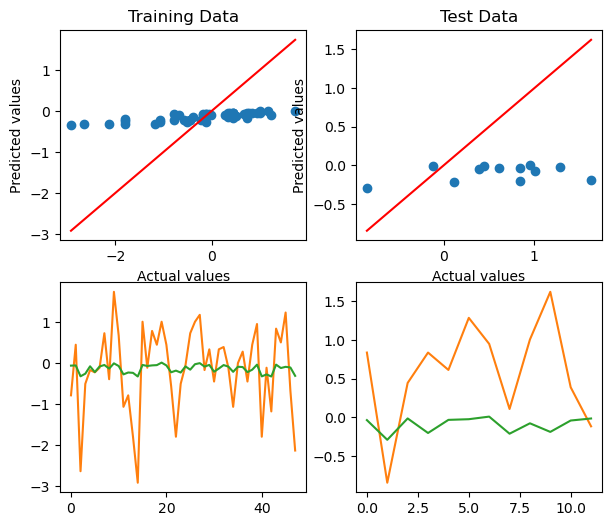

Epoch 100, Training Loss: 0.0138
Train R²:  0.98668
Test R² :  0.45276


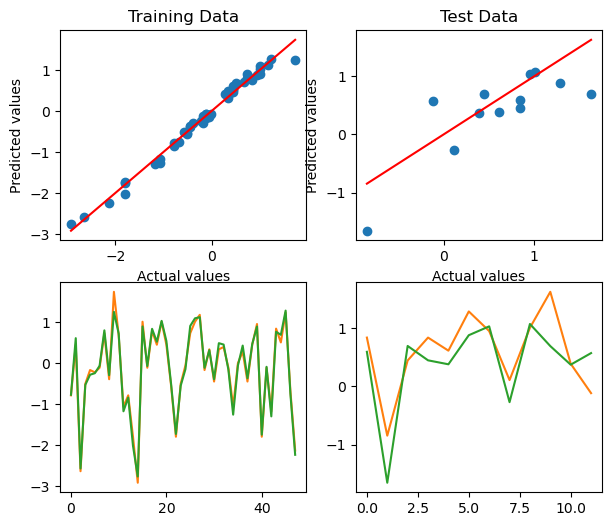

Epoch 150, Training Loss: 0.0043
Train R²:  0.99591
Test R² :  0.39270


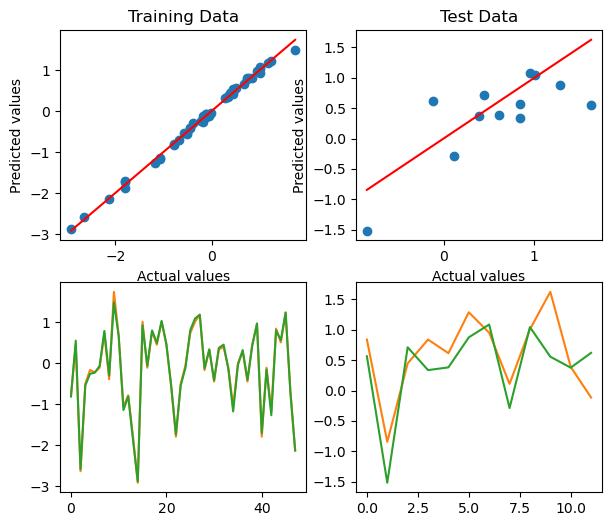

Epoch 200, Training Loss: 0.0022
Train R²:  0.99793
Test R² :  0.38751


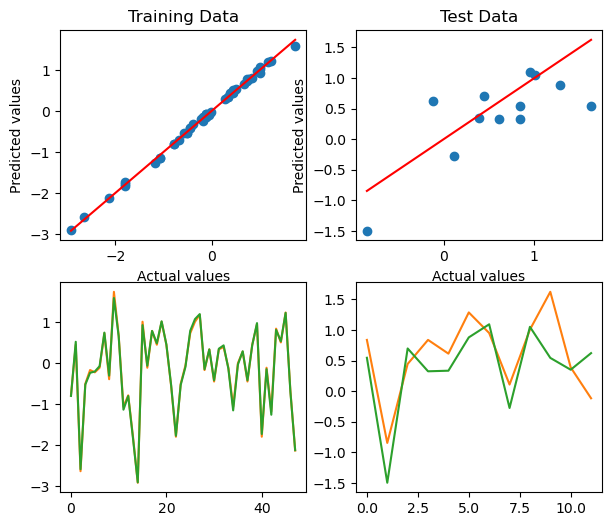

Epoch 250, Training Loss: 0.0014
Train R²:  0.99867
Test R² :  0.37915


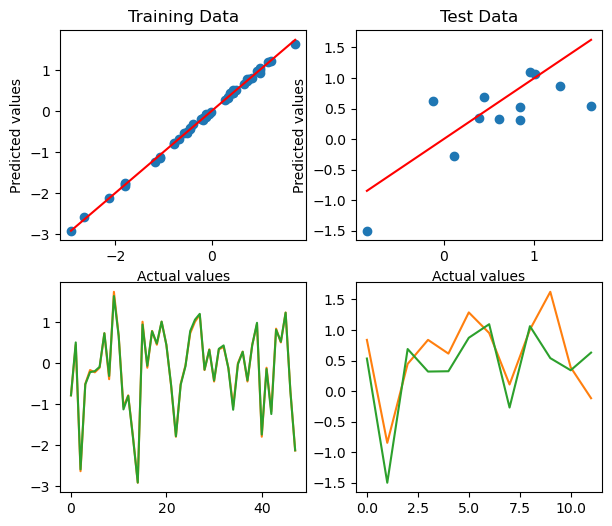

Epoch 300, Training Loss: 0.0010
Train R²:  0.99907
Test R² :  0.37555


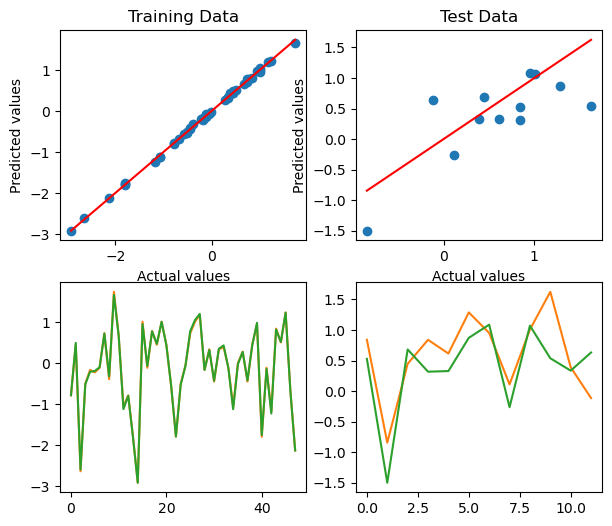

Epoch 350, Training Loss: 0.0007
Train R²:  0.99933
Test R² :  0.37516


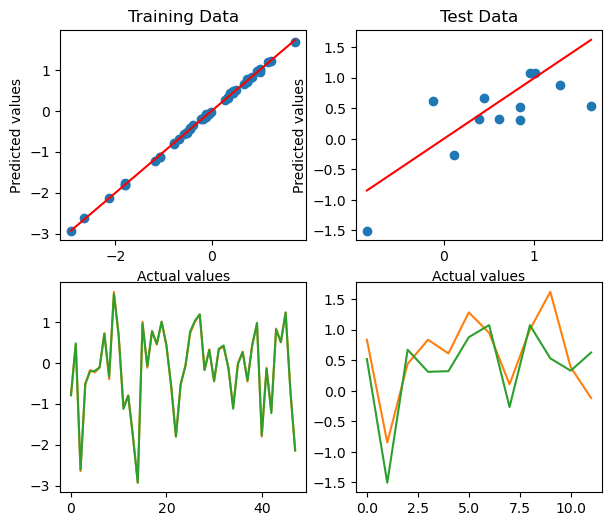

Epoch 400, Training Loss: 0.0005
Train R²:  0.99950
Test R² :  0.37424


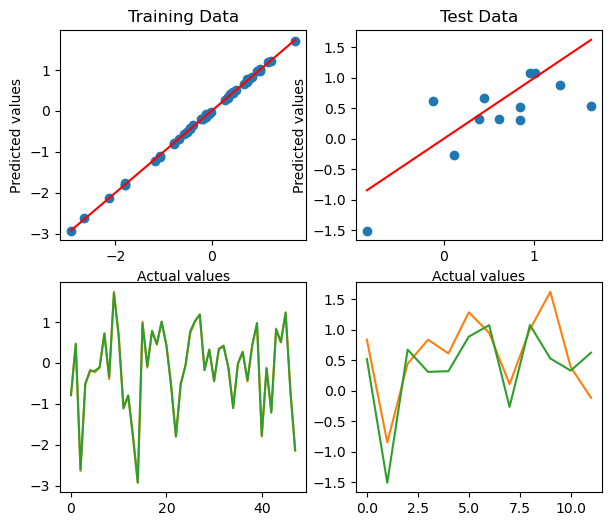

Epoch 450, Training Loss: 0.0004
Train R²:  0.99960
Test R² :  0.37270


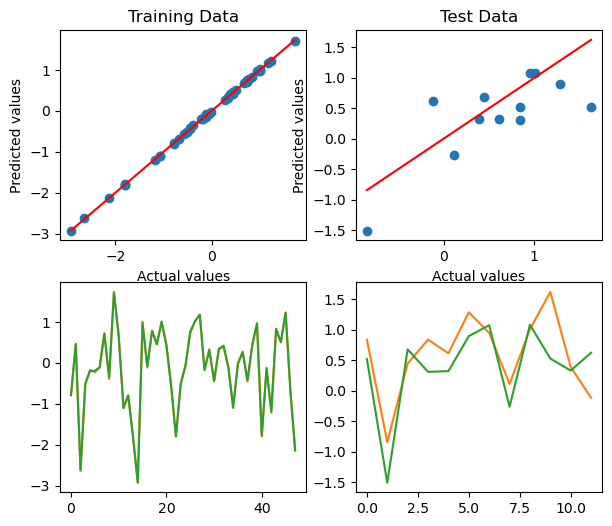

Epoch 500, Training Loss: 0.0003
Train R²:  0.99968
Test R² :  0.37054


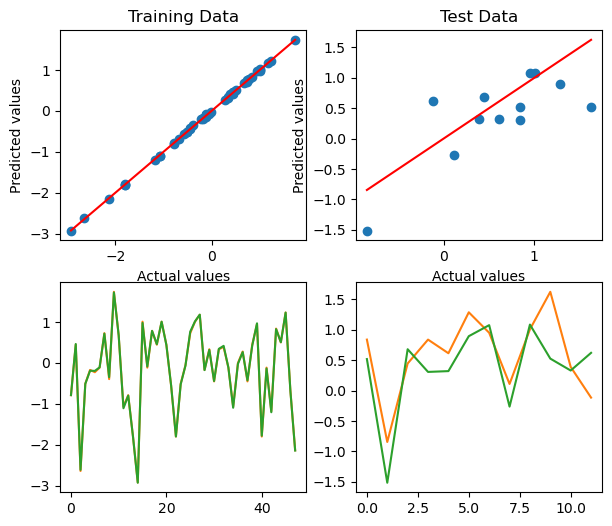

Epoch 550, Training Loss: 0.0003
Train R²:  0.99973
Test R² :  0.36848


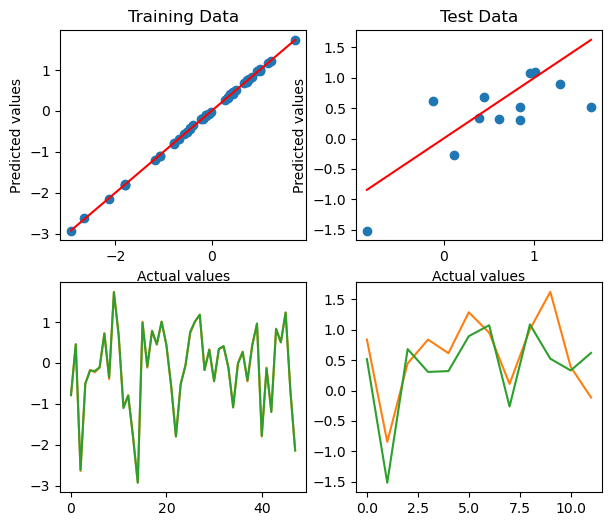

Epoch 600, Training Loss: 0.0002
Train R²:  0.99977
Test R² :  0.36650


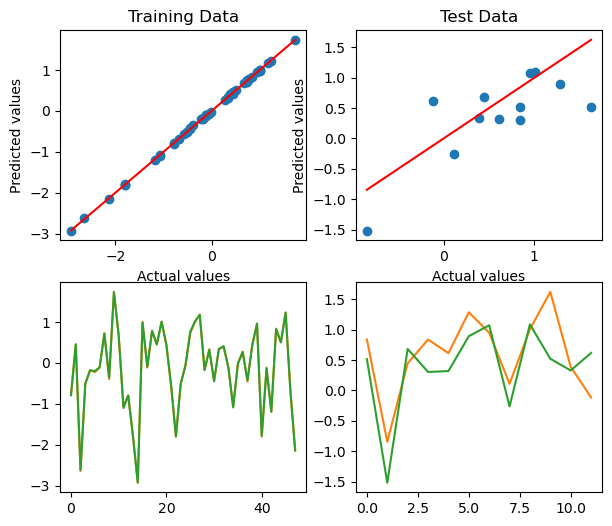

Epoch 650, Training Loss: 0.0002
Train R²:  0.99981
Test R² :  0.36497


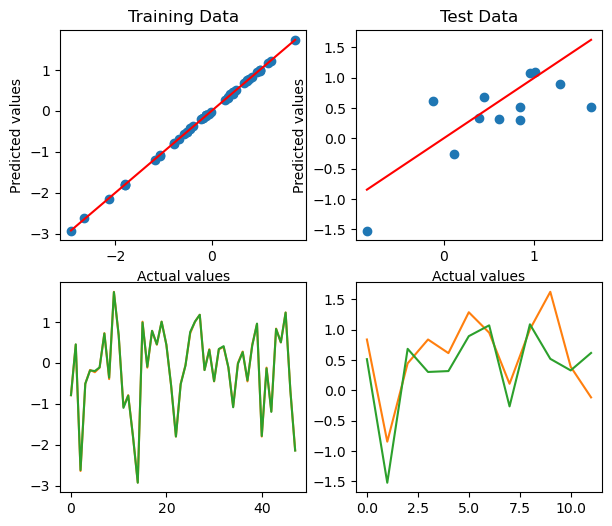

Epoch 700, Training Loss: 0.0002
Train R²:  0.99983
Test R² :  0.36377


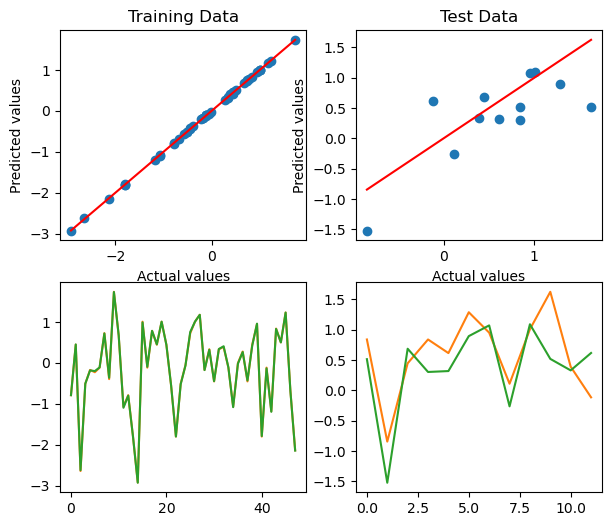

Epoch 750, Training Loss: 0.0001
Train R²:  0.99986
Test R² :  0.36246


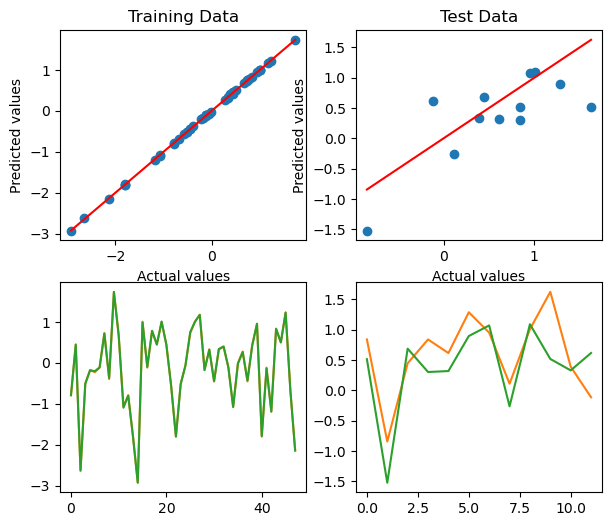

Epoch 800, Training Loss: 0.0001
Train R²:  0.99988
Test R² :  0.36138


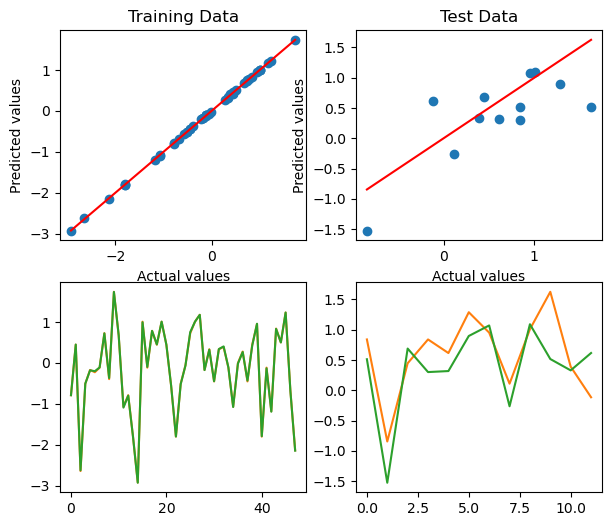

Epoch 850, Training Loss: 0.0001
Train R²:  0.99989
Test R² :  0.36047


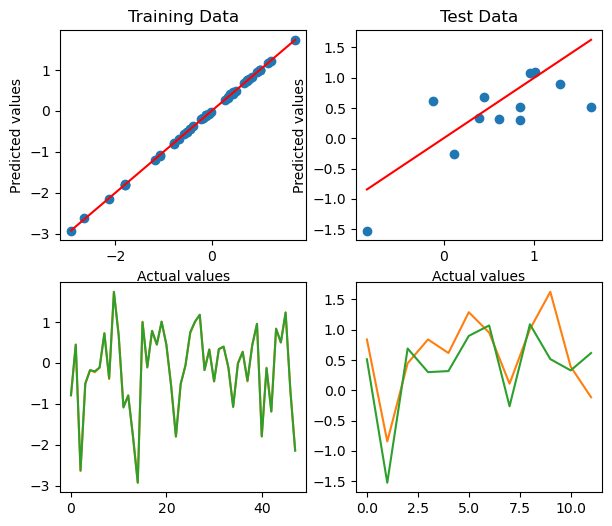

Epoch 900, Training Loss: 0.0001
Train R²:  0.99990
Test R² :  0.35983


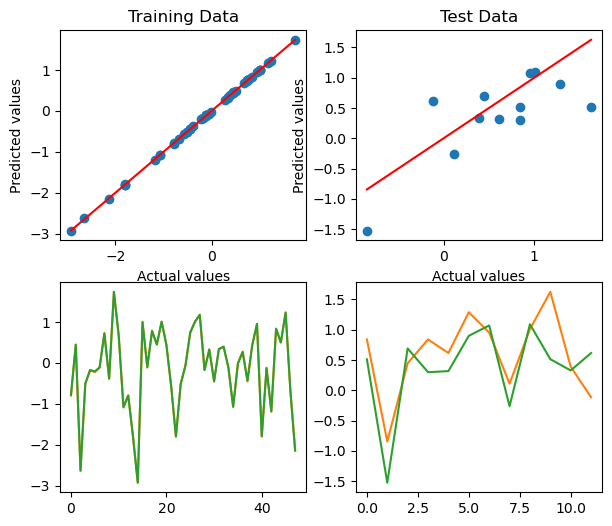

Epoch 950, Training Loss: 0.0001
Train R²:  0.99992
Test R² :  0.35918


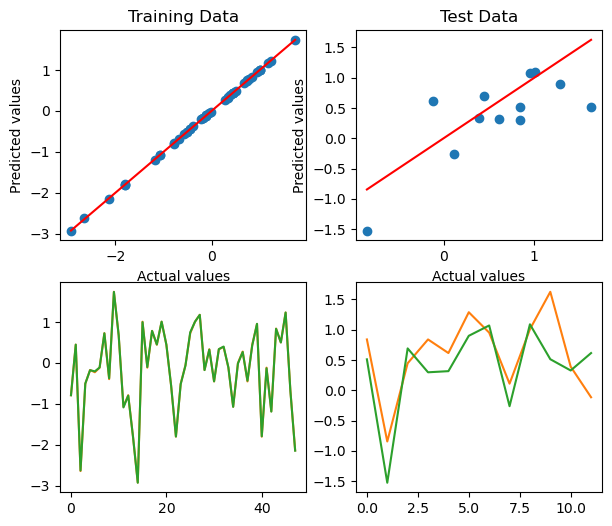

Epoch 1000, Training Loss: 0.0001
Train R²:  0.99993
Test R² :  0.35872


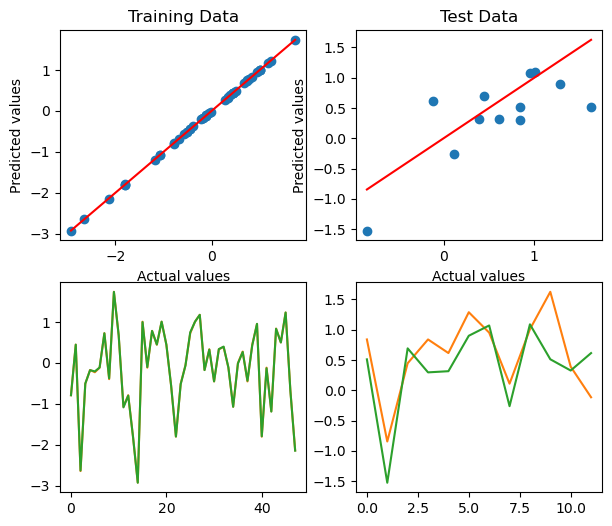

In [41]:
X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

# Use scaled data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=10)

# Convert y to float and flatten
y_train = np.array(y_train, dtype=np.float32).ravel()
y_test = np.array(y_test, dtype=np.float32).ravel()

# Train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=70000, learning_rate=0.001, max_depth=4, random_state=10, tol=1e-5)
gbr.fit(X_train, y_train)

# Get GBR predictions
gbr_train_pred = gbr.predict(X_train)
gbr_test_pred = gbr.predict(X_test)

# Augment inputs
X_train_nn = np.hstack([X_train, gbr_train_pred.reshape(-1, 1)])
X_test_nn = np.hstack([X_test, gbr_test_pred.reshape(-1, 1)])

# Convert to tensors
X_train = torch.tensor(X_train_nn, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test_nn, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

# Neural network class
class DeepNN(nn.Module):
    def __init__(self, input_size=6, hidden_size= 32, output_size=1):
        super(DeepNN, self).__init__()
        # self.fc1 = nn.Linear(input_size, hidden_size)
        # self.activation = nn.ReLU()
        # self.out = nn.Linear(hidden_size, output_size)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, hidden_size)
        self.fc4 = nn.Linear(hidden_size, hidden_size)
        self.fc5 = nn.Linear(hidden_size, hidden_size)
        self.fc6 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x = self.activation(self.fc1(x))
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = torch.relu(self.fc5(x))
        x = self.fc6(x)
        return x

# Model, loss, optimizer
model = DeepNN()
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    model.train()
    y_train_pred = model(X_train)
    loss = criterion(y_train_pred, y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 50 == 0:
        model.eval()
        y_test_pred = model(X_test)
        train_r2 = r2_score(y_train.detach().numpy(), y_train_pred.detach().numpy())
        test_r2 = r2_score(y_test.detach().numpy(), y_test_pred.detach().numpy())
       
        print(f"Epoch {epoch+1}, Training Loss: {loss.item():.4f}")
        print("Train R²: ", "%.5f" % round(train_r2, 5))
        print("Test R² : ", "%.5f" % round(test_r2, 5))

        fig, axes = plt.subplots(2, 2, figsize = (7, 6))
        axes[0, 0].scatter(y_train, y_train_pred.detach().numpy())
        axes[0, 0].plot([min(y_train.data.numpy()), max(y_train.data.numpy())],[min(y_train.data.numpy()), max(y_train.data.numpy())], color = 'r')
        axes[0, 0].set_title("Training Data")
        axes[0, 0].set_xlabel("Actual values")
        axes[0, 0].set_ylabel("Predicted values")

        axes[0, 1].scatter(y_test, y_test_pred.detach().numpy())
        axes[0, 1].plot([min(y_test.data.numpy()), max(y_test.data.numpy())],[min(y_test.data.numpy()), max(y_test.data.numpy())], color = 'r')
        axes[0, 1].set_title("Test Data")
        axes[0, 1].set_xlabel("Actual values")
        axes[0, 1].set_ylabel("Predicted values")

        axes[1, 0].plot(y_train.data.numpy().squeeze(),'tab:orange', label = 'real')
        axes[1, 0].plot(y_train_pred.detach().numpy(),'tab:green',label = 'pred')

        axes[1, 1].plot(y_test.data.numpy().squeeze(), 'tab:orange',label = 'real')
        axes[1, 1].plot(y_test_pred.detach().numpy(),'tab:green',label = 'pred')

        plt.draw();plt.pause(0.05)
    
    plt.ioff()
    plt.show()


# GBR Optimisation

Train R^2:  1.0
Test  R^2:  0.3804511874364702


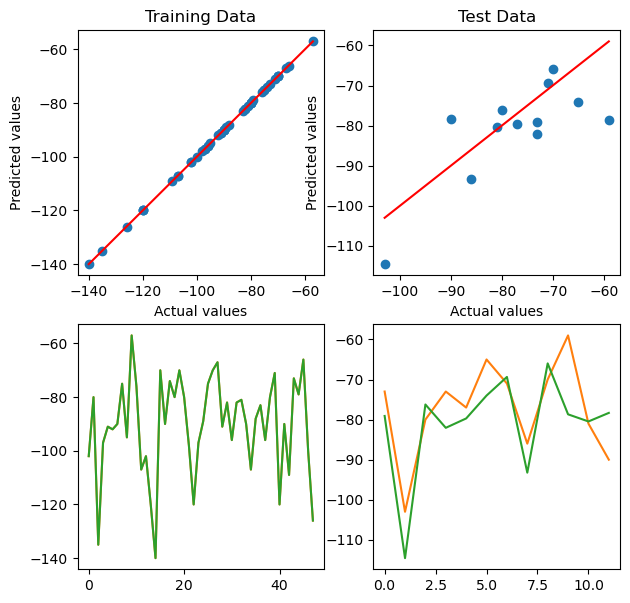

In [20]:
root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

y_train = np.array(y_train,dtype = np.float32).ravel()
y_test = np.array(y_test,dtype = np.float32).ravel()

# 2. Train the Gradient Boosting Regressor # n = 10000, rs = 42, max_depth = 2 (Original)
gbr = GradientBoostingRegressor(n_estimators = 70000, learning_rate = 0.001, max_depth = 4, random_state = 10, tol = 1e-5)
gbr.fit(X_train, y_train)

# Get the predictions from Gradient Boosting Regressor
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

var_train = r2_score(y_train, y_train_pred)
var_test  = r2_score(y_test, y_test_pred)

print("Train R^2: ", var_train)
print("Test  R^2: ", var_test)


fig, axes = plt.subplots(2, 2, figsize = (7, 7))
axes[0, 0].scatter(y_train, y_train_pred)
axes[0, 0].plot([min(y_train), max(y_train)],[min(y_train), max(y_train)], color = 'r')
axes[0, 0].set_title("Training Data")
axes[0, 0].set_xlabel("Actual values")
axes[0, 0].set_ylabel("Predicted values")

axes[0, 1].scatter(y_test, y_test_pred)
axes[0, 1].plot([min(y_test), max(y_test)],[min(y_test), max(y_test)], color = 'r')
axes[0, 1].set_title("Test Data")
axes[0, 1].set_xlabel("Actual values")
axes[0, 1].set_ylabel("Predicted values")

axes[1, 0].plot(y_train,'tab:orange', label = 'real')
axes[1, 0].plot(y_train_pred,'tab:green',label = 'pred')

axes[1, 1].plot(y_test, 'tab:orange',label = 'real')
axes[1, 1].plot(y_test_pred,'tab:green',label = 'pred')

plt.draw();plt.pause(0.05)

plt.ioff()
plt.show()

Train R^2:  0.9999999288653757
Test  R^2:  0.05512023951136047


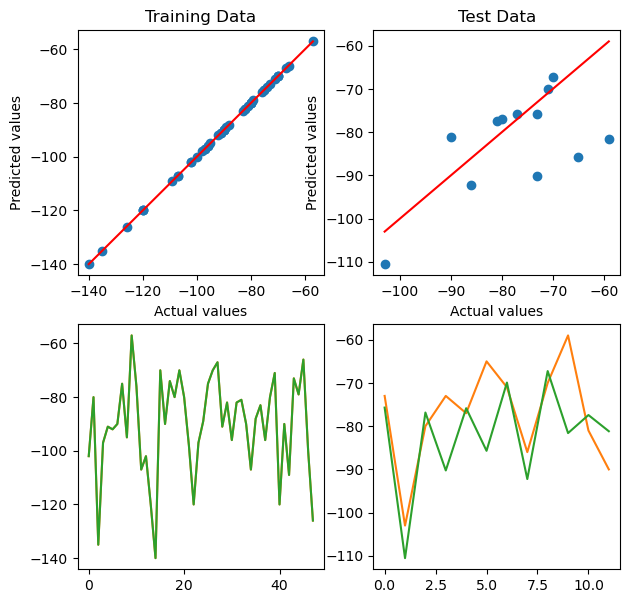

In [18]:
root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

y_train = np.array(y_train,dtype = np.float32).ravel()
y_test = np.array(y_test,dtype = np.float32).ravel()

# 2. Train the Gradient Boosting Regressor # n = 10000
gbr = GradientBoostingRegressor(n_estimators = 100000, learning_rate = 0.001, max_depth = 2, random_state = 42, tol = 1e-5)
gbr.fit(X_train, y_train)

# Get the predictions from Gradient Boosting Regressor
y_train_pred = gbr.predict(X_train)
y_test_pred = gbr.predict(X_test)

var_train = r2_score(y_train, y_train_pred)
var_test  = r2_score(y_test, y_test_pred)

print("Train R^2: ", var_train)
print("Test  R^2: ", var_test)


fig, axes = plt.subplots(2, 2, figsize = (7, 7))
axes[0, 0].scatter(y_train, y_train_pred)
axes[0, 0].plot([min(y_train), max(y_train)],[min(y_train), max(y_train)], color = 'r')
axes[0, 0].set_title("Training Data")
axes[0, 0].set_xlabel("Actual values")
axes[0, 0].set_ylabel("Predicted values")

axes[0, 1].scatter(y_test, y_test_pred)
axes[0, 1].plot([min(y_test), max(y_test)],[min(y_test), max(y_test)], color = 'r')
axes[0, 1].set_title("Test Data")
axes[0, 1].set_xlabel("Actual values")
axes[0, 1].set_ylabel("Predicted values")

axes[1, 0].plot(y_train,'tab:orange', label = 'real')
axes[1, 0].plot(y_train_pred,'tab:green',label = 'pred')

axes[1, 1].plot(y_test, 'tab:orange',label = 'real')
axes[1, 1].plot(y_test_pred,'tab:green',label = 'pred')

plt.draw();plt.pause(0.05)

plt.ioff()
plt.show()

## GBR Automated Process

In [4]:
root = "tensile_fatigue_data_v14.xlsx"
main_df = pd.read_excel(root)

X = pd.read_excel(root,usecols=[0,1,2,3,4])
y = pd.read_excel(root,usecols=[6])

# Normalize inputs
scaler_X = StandardScaler()
X_scaled = scaler_X.fit_transform(X)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 10)

y_train = np.array(y_train,dtype = np.float32).ravel()
y_test = np.array(y_test,dtype = np.float32).ravel()

# 2. Train the Gradient Boosting Regressor
gbr = GradientBoostingRegressor(random_state = 10, tol = 1e-5)

n_estimate = [30000, 50000]
l_rate = [0.001, 0.01, 0.1, 0.2]
m_depth = [2, 3, 4]
max_test_score = 0
max_n = 0
max_l = 0
max_d = 0

# 'subsample': [0.8, 1.0]
# 'min_samples_split': [2, 5]

for x in range(len(n_estimate)):
    for y in range(len(l_rate)):
        for z in range(len(m_depth)):
            gbr = GradientBoostingRegressor(n_estimators = n_estimate[x],learning_rate = l_rate[y], max_depth = m_depth[z], random_state = 10, tol = 1e-5)
            gbr.fit(X_train, y_train)

            y_train_pred = gbr.predict(X_train)
            y_test_pred = gbr.predict(X_test)

            r2_train = r2_score(y_train, y_train_pred)
            r2_test  = r2_score(y_test, y_test_pred)

            print("GBR Parameters: n-estimators = ", n_estimate[x], " lr = ", l_rate[y], " max depth = ", m_depth[z])
            print("Train R²: ", "%.5f" % round(r2_train, 5))
            print("Test R² : ", "%.5f" % round(r2_test, 5))

            if r2_test > max_test_score:
                max_test_score = r2_test
                max_n = n_estimate[x]
                max_l = l_rate[y]
                max_d = m_depth[z]

print("Best GBR Parameters: n-estimators = ", max_n, " lr = ", max_l, " max depth = ", max_d)

GBR Parameters: n-estimators =  10000  lr =  0.001  max depth =  2
Train R²:  0.94675
Test R² :  -0.06085
GBR Parameters: n-estimators =  10000  lr =  0.001  max depth =  3
Train R²:  0.99573
Test R² :  0.20012
GBR Parameters: n-estimators =  10000  lr =  0.001  max depth =  4
Train R²:  0.99978
Test R² :  0.36011
GBR Parameters: n-estimators =  10000  lr =  0.001  max depth =  5
Train R²:  1.00000
Test R² :  -0.22125
GBR Parameters: n-estimators =  10000  lr =  0.01  max depth =  2
Train R²:  1.00000
Test R² :  0.10287
GBR Parameters: n-estimators =  10000  lr =  0.01  max depth =  3
Train R²:  1.00000
Test R² :  0.20717
GBR Parameters: n-estimators =  10000  lr =  0.01  max depth =  4
Train R²:  1.00000
Test R² :  0.21782
GBR Parameters: n-estimators =  10000  lr =  0.01  max depth =  5
Train R²:  1.00000
Test R² :  -0.24173
GBR Parameters: n-estimators =  10000  lr =  0.1  max depth =  2
Train R²:  1.00000
Test R² :  0.18249
GBR Parameters: n-estimators =  10000  lr =  0.1  max dept